# Import Library

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath('../'))
from LSTM.LSTMFromScratch import LSTMFromScratch

In [5]:
# Set a random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load Datasets

In [6]:
try:
    train_df = pd.read_csv('../dataset/train.csv')
    valid_df = pd.read_csv('../dataset/valid.csv')
    test_df = pd.read_csv('../dataset/test.csv')
except FileNotFoundError:
    print("Directory invalid!.")
    exit()

X_train, y_train = train_df['text'], train_df['label']
X_val, y_val = valid_df['text'], valid_df['label']
X_test, y_test = test_df['text'], test_df['label']

# Text Vectorization

In [22]:
# TextVectorization
max_features = 5000
sequence_length = 100

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorize_layer.adapt(X_train)

In [23]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

X_train_vec = vectorize_text(X_train).numpy()
X_val_vec = vectorize_text(X_val).numpy()
X_test_vec = vectorize_text(X_test).numpy()

In [24]:
# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

y_train_np = np.array(y_train_enc)
y_val_np = np.array(y_val_enc)
y_test_np = np.array(y_test_enc)

print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"y_train_np shape: {y_train_np.shape}")
print(f"X_val_vec shape: {X_val_vec.shape}")
print(f"y_val_np shape: {y_val_np.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")
print(f"y_test_np shape: {y_test_np.shape}")

vocab_size = len(vectorize_layer.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")
num_classes = len(np.unique(y_train_np))
print(f"Number of classes: {num_classes}")

X_train_vec shape: (500, 100)
y_train_np shape: (500,)
X_val_vec shape: (100, 100)
y_val_np shape: (100,)
X_test_vec shape: (400, 100)
y_test_np shape: (400,)
Vocabulary size: 2836
Number of classes: 3


# Modeling LSTM From Keras

In [ ]:
class F1Score(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []
        self.val_f1_scores = []
    
    def on_epoch_end(self, epoch, logs=None):
        # Training F1
        train_pred = self.model.predict(self.validation_data[0], verbose=0)
        train_pred_classes = np.argmax(train_pred, axis=1)
        train_f1 = f1_score(self.validation_data[1], train_pred_classes, average='macro', zero_division=0)
        
        # Validation F1
        val_pred = self.model.predict(self.validation_data[2], verbose=0)
        val_pred_classes = np.argmax(val_pred, axis=1)
        val_f1 = f1_score(self.validation_data[3], val_pred_classes, average='macro', zero_division=0)
        
        self.f1_scores.append(train_f1)
        self.val_f1_scores.append(val_f1)
        
        logs = logs or {}
        logs['f1_macro'] = train_f1
        logs['val_f1_macro'] = val_f1
        
        print(f" - f1_macro: {train_f1:.4f} - val_f1_macro: {val_f1:.4f}")

# Plot history function
def plot_history(history, title, f1_callback=None):
    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot F1-score
    plt.subplot(1, 2, 2)
    if f1_callback and len(f1_callback.f1_scores) > 0:
        plt.plot(f1_callback.f1_scores, label='Training F1-macro', marker='^')
        plt.plot(f1_callback.val_f1_scores, label='Validation F1-macro', marker='d')
        plt.title(f'{title} - F1-macro Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1-macro Score')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "F1-macro scores unavailable", 
                horizontalalignment='center', verticalalignment='center', 
                transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()

In [30]:
# Base training parameters
embedding_dim = 256 
epochs = 10
batch_size = 32

In [34]:
def create_lstm_model(lstm_layers_config, dropout_rate=0.5):
    model = Sequential()
    
    model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
    
    for i, (lstm_layer_type, cells) in enumerate(lstm_layers_config):
        return_sequences = (i < len(lstm_layers_config) - 1)
        
        if lstm_layer_type == 'lstm':
            model.add(LSTM(cells, return_sequences=return_sequences))
        elif lstm_layer_type == 'bidirectional_lstm':
            model.add(Bidirectional(LSTM(cells, return_sequences=return_sequences)))
        
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.build(input_shape=(None, sequence_length))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model

# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

# 1. Pengaruh Jumlah Layer LSTM


Training with 1 Bidirectional LSTM layer(s)...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 890,755 (3.40 MB)

 Trainable params: 890,755 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4244 - loss: 1.0769 - f1_macro: 0.5504 - val_f1_macro: 0.4348
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4274 - loss: 1.0759 - val_accuracy: 0.4300 - val_loss: 1.0276 - f1_macro: 0.5504 - val_f1_macro: 0.4348
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5278 - loss: 0.9769 - f1_macro: 0.6669 - val_f1_macro: 0.5155
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5313 - loss: 0.9740 - val_accuracy: 0.5800 - val_loss: 0.9306 - f1_macro: 0.6669 - val_f1_macro: 0.5155
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7020 - loss: 0.7715 - f1_macro: 0.8205 - val_f1_macro: 0.6272
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7032 - loss: 0.7672 - val_accuracy: 0.6400 - val_loss: 0.8209 - f1_macro: 0.8205 - val_f1_macro: 0.6272
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8465 - loss: 0.4992 - f1_macro: 0.9390 - val_f1_macro: 0.7325
16/16 ━━━━━━━━━━━

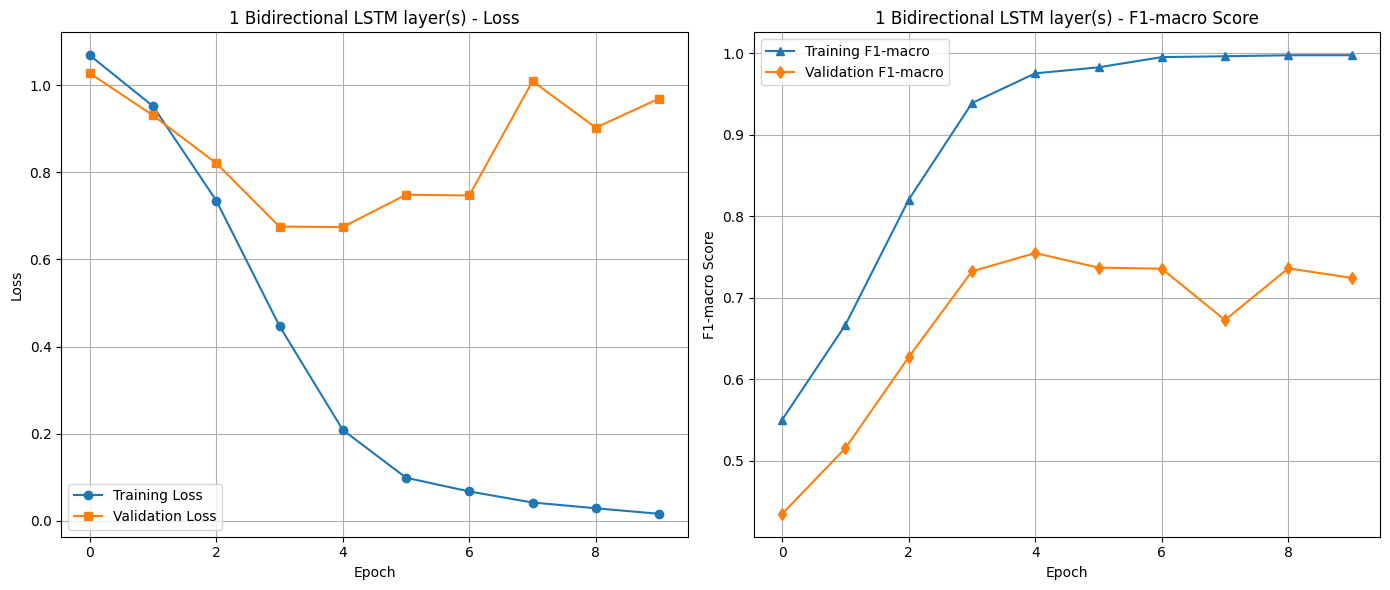


Training with 2 Bidirectional LSTM layer(s)...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 100, 128)       │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 989,571 (3.77 MB)

 Trainable params: 989,571 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3984 - loss: 1.0713 - f1_macro: 0.5321 - val_f1_macro: 0.4467
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.4004 - loss: 1.0697 - val_accuracy: 0.4500 - val_loss: 0.9935 - f1_macro: 0.5321 - val_f1_macro: 0.4467
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5734 - loss: 0.9079 - f1_macro: 0.6797 - val_f1_macro: 0.5360
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.5742 - loss: 0.9057 - val_accuracy: 0.5500 - val_loss: 0.8866 - f1_macro: 0.6797 - val_f1_macro: 0.5360
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6972 - loss: 0.6968 - f1_macro: 0.8524 - val_f1_macro: 0.5652
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.6971 - loss: 0.6943 - val_accuracy: 0.6600 - val_loss: 0.7418 - f1_macro: 0.8524 - val_f1_macro: 0.5652
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9054 - loss: 0.4211 - f1_macro: 0.9530 - val_f1_macro: 0.6967
16/16 ━━━━━━━━━

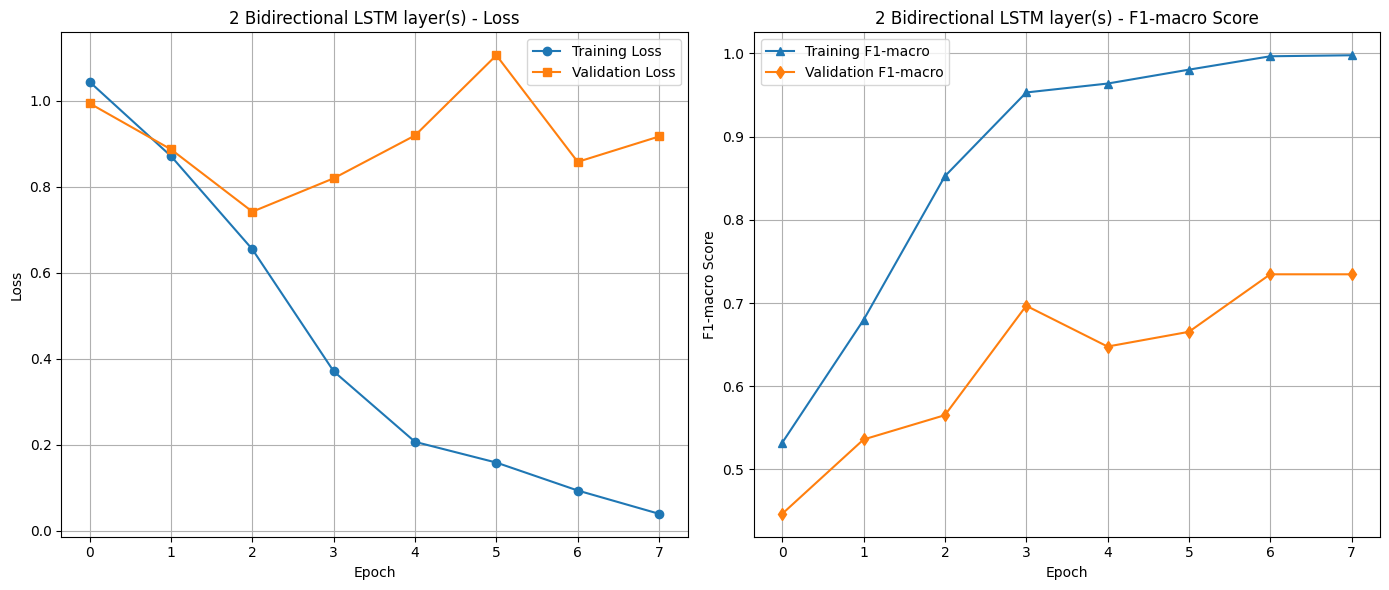


Training with 3 Bidirectional LSTM layer(s)...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 100, 128)       │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 100, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,088,387 (4.15 MB)

 Trainable params: 1,088,387 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4476 - loss: 1.0631 - f1_macro: 0.4770 - val_f1_macro: 0.4589
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.4494 - loss: 1.0615 - val_accuracy: 0.5100 - val_loss: 0.9638 - f1_macro: 0.4770 - val_f1_macro: 0.4589
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5602 - loss: 0.8841 - f1_macro: 0.7073 - val_f1_macro: 0.5371
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5620 - loss: 0.8817 - val_accuracy: 0.5900 - val_loss: 0.8204 - f1_macro: 0.7073 - val_f1_macro: 0.5371
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7196 - loss: 0.5838 - f1_macro: 0.8687 - val_f1_macro: 0.5785
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.7192 - loss: 0.5836 - val_accuracy: 0.6400 - val_loss: 0.8473 - f1_macro: 0.8687 - val_f1_macro: 0.5785
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8159 - loss: 0.4297 - f1_macro: 0.8879 - val_f1_macro: 0.6392
16/16 ━━━━━

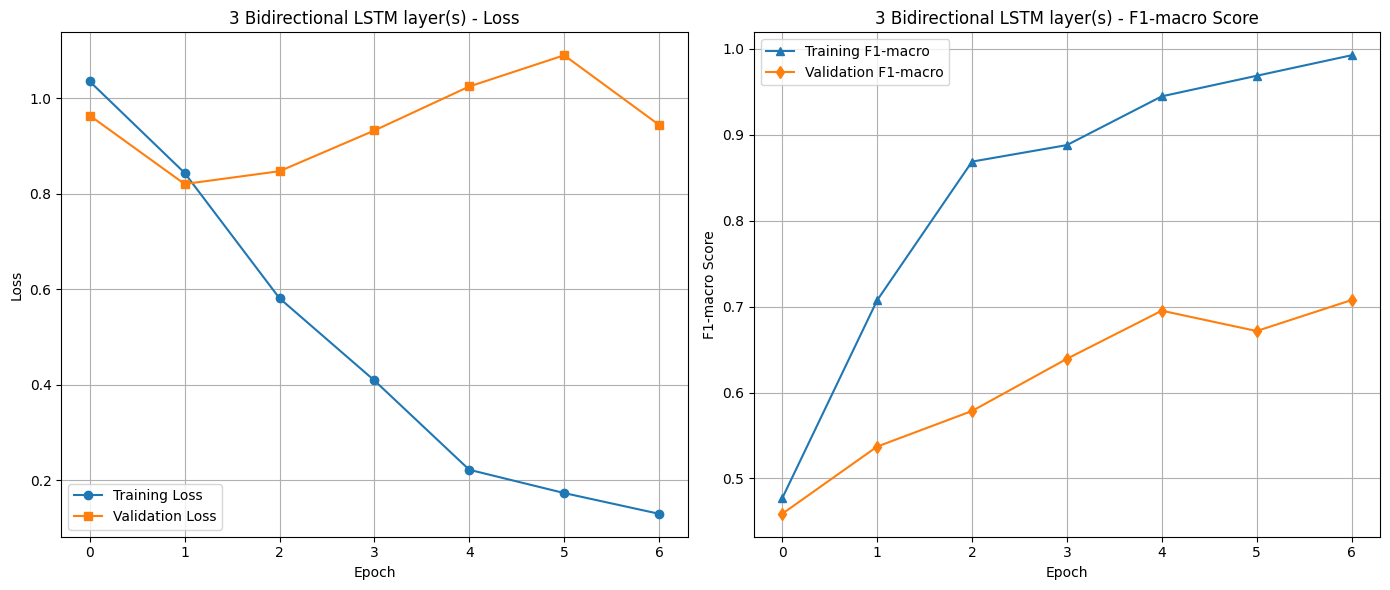


Comparison of Number of LSTM Layers:
Model: num_layers_1_bidirectional_lstm, Macro F1-score: 0.7505
Model: num_layers_2_bidirectional_lstm, Macro F1-score: 0.5604
Model: num_layers_3_bidirectional_lstm, Macro F1-score: 0.5914


In [ ]:
lstm_layer_configs_num_layers = [
    [('bidirectional_lstm', 64)],
    [('bidirectional_lstm', 64), ('bidirectional_lstm', 64)],
    [('bidirectional_lstm', 64), ('bidirectional_lstm', 64), ('bidirectional_lstm', 64)],
]

histories_num_layers = {}
f1_scores_num_layers = {}
f1_callbacks_num_layers = {}

for i, config in enumerate(lstm_layer_configs_num_layers):
    num_layers_str = f"{len(config)} {'Bidirectional LSTM' if config[0][0].startswith('bidirectional') else 'LSTM'} layer(s)"
    print(f"\nTraining with {num_layers_str}...")
    
    model_name = f"num_layers_{len(config)}_{config[0][0]}"
    model = create_lstm_model(config)
    model.summary()

    f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))
    
    history = model.fit(X_train_vec, y_train_np,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_val_vec, y_val_np),
                       callbacks=[early_stopping, f1_callback],
                       verbose=1)
    
    histories_num_layers[model_name] = history
    f1_callbacks_num_layers[model_name] = f1_callback
    
    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_num_layers[model_name] = macro_f1
    
    print(f"Macro F1-score for {num_layers_str}: {macro_f1:.4f}")
    plot_history(history, f"{num_layers_str}", f1_callback)

print("\nComparison of Number of LSTM Layers:")
for name, f1 in f1_scores_num_layers.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 2. Pengaruh Banyak Cell RNN per Layer


Training with Bidirectional LSTM with 32 cells...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,195 (3.05 MB)

 Trainable params: 800,195 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3961 - loss: 1.0838 - f1_macro: 0.4959 - val_f1_macro: 0.4678
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.3960 - loss: 1.0832 - val_accuracy: 0.6100 - val_loss: 1.0336 - f1_macro: 0.4959 - val_f1_macro: 0.4678
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6178 - loss: 0.9709 - f1_macro: 0.6104 - val_f1_macro: 0.4893
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6169 - loss: 0.9694 - val_accuracy: 0.6100 - val_loss: 0.9083 - f1_macro: 0.6104 - val_f1_macro: 0.4893
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6915 - loss: 0.7884 - f1_macro: 0.8273 - val_f1_macro: 0.5692
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6890 - loss: 0.7861 - val_accuracy: 0.6300 - val_loss: 0.8255 - f1_macro: 0.8273 - val_f1_macro: 0.5692
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8063 - loss: 0.5973 - f1_macro: 0.8195 - val_f1_macro: 0.5289
16/16 ━━━━━━━━━━━━

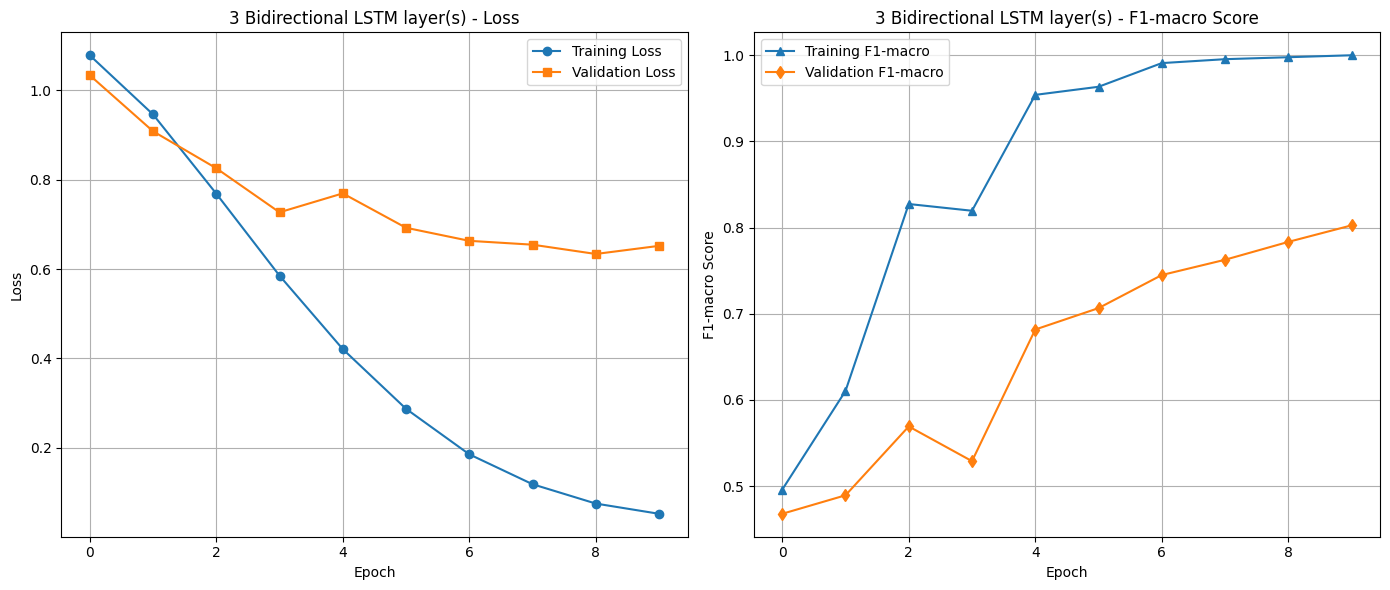


Training with Bidirectional LSTM with 64 cells...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 890,755 (3.40 MB)

 Trainable params: 890,755 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3740 - loss: 1.0837 - f1_macro: 0.4788 - val_f1_macro: 0.4395
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.3770 - loss: 1.0834 - val_accuracy: 0.5700 - val_loss: 1.0242 - f1_macro: 0.4788 - val_f1_macro: 0.4395
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6351 - loss: 0.9464 - f1_macro: 0.5981 - val_f1_macro: 0.4893
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6327 - loss: 0.9430 - val_accuracy: 0.6100 - val_loss: 0.8727 - f1_macro: 0.5981 - val_f1_macro: 0.4893
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6984 - loss: 0.6959 - f1_macro: 0.8743 - val_f1_macro: 0.6462
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7035 - loss: 0.6904 - val_accuracy: 0.6700 - val_loss: 0.7329 - f1_macro: 0.8743 - val_f1_macro: 0.6462
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8932 - loss: 0.4057 - f1_macro: 0.9255 - val_f1_macro: 0.7043
16/16 ━━━━━━━━━━━━

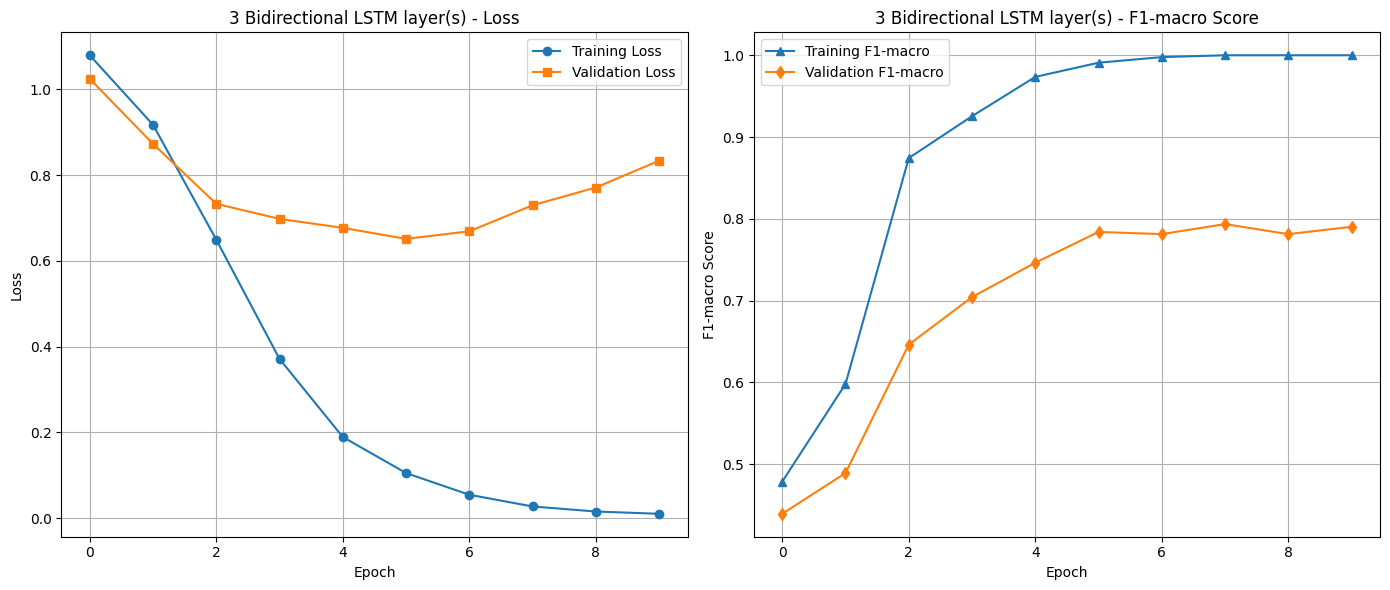


Training with Bidirectional LSTM with 128 cells...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121,027 (4.28 MB)

 Trainable params: 1,121,027 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3782 - loss: 1.0759 - f1_macro: 0.5977 - val_f1_macro: 0.5296
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.3800 - loss: 1.0746 - val_accuracy: 0.5600 - val_loss: 0.9804 - f1_macro: 0.5977 - val_f1_macro: 0.5296
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5765 - loss: 0.8950 - f1_macro: 0.6995 - val_f1_macro: 0.5313
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.5774 - loss: 0.8932 - val_accuracy: 0.5400 - val_loss: 0.8864 - f1_macro: 0.6995 - val_f1_macro: 0.5313
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7311 - loss: 0.6770 - f1_macro: 0.8330 - val_f1_macro: 0.6063
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7319 - loss: 0.6750 - val_accuracy: 0.6100 - val_loss: 0.8132 - f1_macro: 0.8330 - val_f1_macro: 0.6063
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8650 - loss: 0.3976 - f1_macro: 0.9129 - val_f1_macro: 0.7107
16/16 ━━━━━━━━━

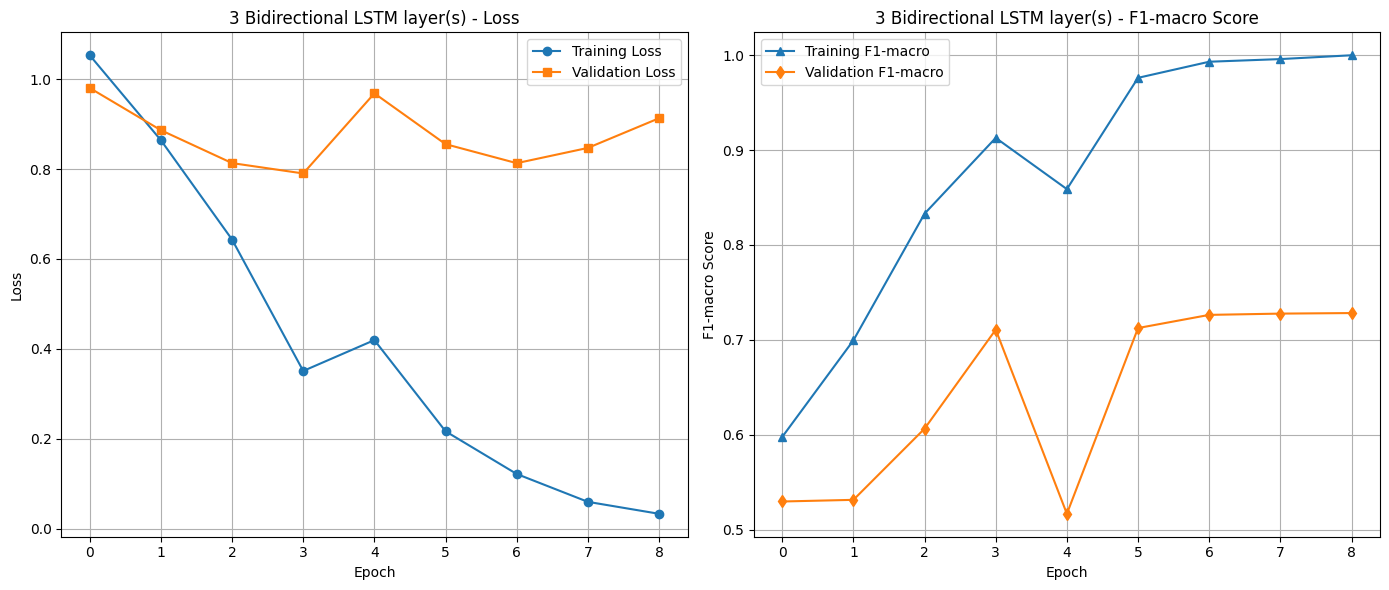


Comparison of Number of LSTM Cells per Layer:
Model: num_cells_32, Macro F1-score: 0.7407
Model: num_cells_64, Macro F1-score: 0.7408
Model: num_cells_128, Macro F1-score: 0.7186


In [38]:
lstm_layer_configs_num_cells = [
    [('bidirectional_lstm', 32)],
    [('bidirectional_lstm', 64)],
    [('bidirectional_lstm', 128)],
]

histories_num_cells = {}
f1_scores_num_cells = {}
f1_callbacks_num_cells = {} 

for i, config in enumerate(lstm_layer_configs_num_cells):
    num_cells_str = f"Bidirectional LSTM with {config[0][1]} cells"
    print(f"\nTraining with {num_cells_str}...")
    
    model_name = f"num_cells_{config[0][1]}"
    model = create_lstm_model(config)
    model.summary()

    f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))
    
    history = model.fit(X_train_vec, y_train_np,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_val_vec, y_val_np),
                       callbacks=[early_stopping, f1_callback], 
                       verbose=1)
    
    histories_num_cells[model_name] = history
    f1_callbacks_num_cells[model_name] = f1_callback 
    
    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_num_cells[model_name] = macro_f1
    
    print(f"Macro F1-score for {num_cells_str}: {macro_f1:.4f}")
    plot_history(history, f"{num_layers_str}", f1_callback)

print("\nComparison of Number of LSTM Cells per Layer:")
for name, f1 in f1_scores_num_cells.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 3. Pengaruh Jenis Layer LSTM Berdasarkan Arah


Training with Unidirectional LSTM...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,523 (3.52 MB)

 Trainable params: 923,523 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3532 - loss: 1.0833 - f1_macro: 0.1829 - val_f1_macro: 0.1836
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.3525 - loss: 1.0838 - val_accuracy: 0.3800 - val_loss: 1.0812 - f1_macro: 0.1829 - val_f1_macro: 0.1836
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4373 - loss: 1.0828 - f1_macro: 0.1850 - val_f1_macro: 0.1836
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4348 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0786 - f1_macro: 0.1850 - val_f1_macro: 0.1836
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3915 - loss: 1.0756 - f1_macro: 0.1829 - val_f1_macro: 0.1836
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.3902 - loss: 1.0761 - val_accuracy: 0.3800 - val_loss: 1.0779 - f1_macro: 0.1829 - val_f1_macro: 0.1836
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4073 - loss: 1.0702 - f1_macro: 0.1829 - val_f1_macro: 0.1836
16/16 ━━━━━━━━━

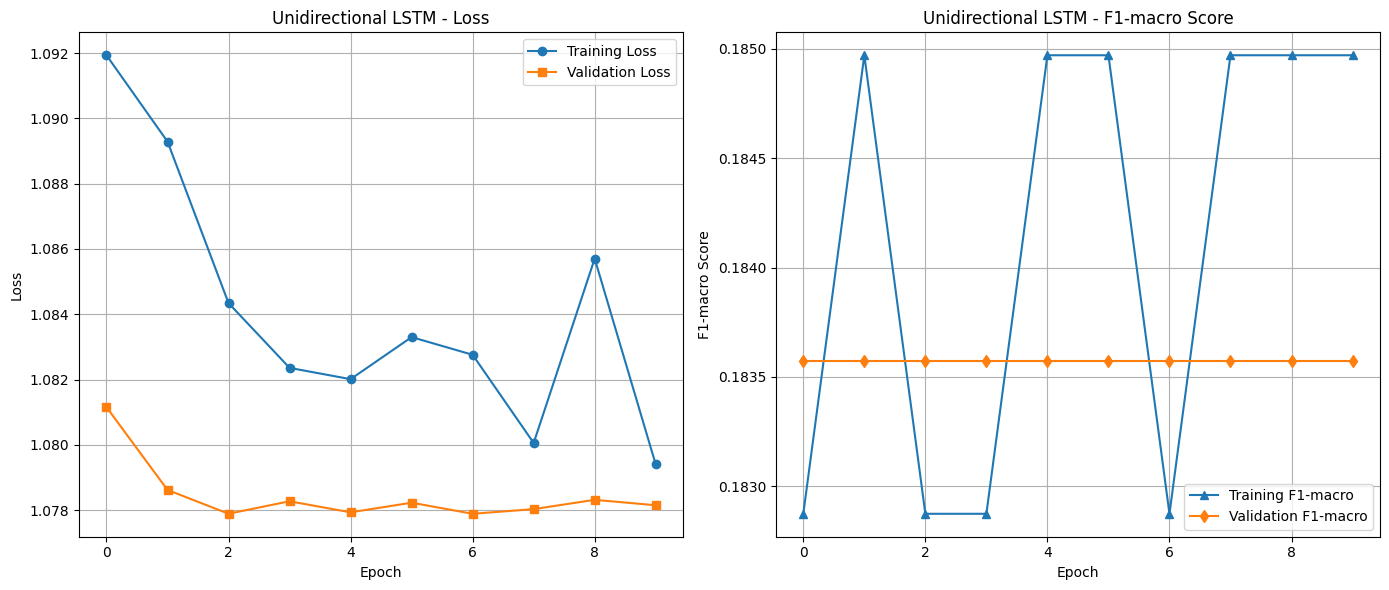


Training with Bidirectional LSTM...


/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121,027 (4.28 MB)

 Trainable params: 1,121,027 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3664 - loss: 1.0668 - f1_macro: 0.5021 - val_f1_macro: 0.4445
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.3692 - loss: 1.0657 - val_accuracy: 0.4500 - val_loss: 1.0204 - f1_macro: 0.5021 - val_f1_macro: 0.4445
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5967 - loss: 0.9132 - f1_macro: 0.6726 - val_f1_macro: 0.5519
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5963 - loss: 0.9114 - val_accuracy: 0.5500 - val_loss: 0.9135 - f1_macro: 0.6726 - val_f1_macro: 0.5519
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6869 - loss: 0.6948 - f1_macro: 0.8217 - val_f1_macro: 0.5742
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6882 - loss: 0.6918 - val_accuracy: 0.6700 - val_loss: 0.7423 - f1_macro: 0.8217 - val_f1_macro: 0.5742
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9031 - loss: 0.3603  - f1_macro: 0.9547 - val_f1_macro: 0.6846
16/16 ━━━━━━━━

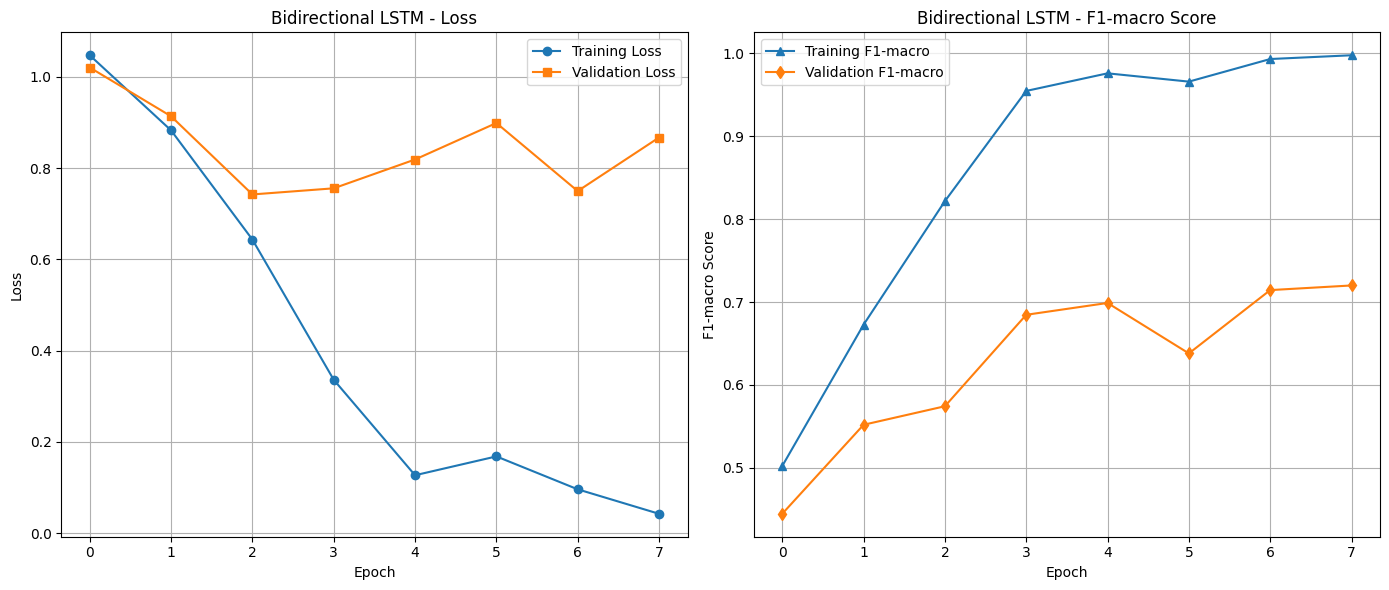


Comparison of LSTM Layer Direction:
Model: direction_lstm, Macro F1-score: 0.1827
Model: direction_bidirectional_lstm, Macro F1-score: 0.5941


In [39]:
lstm_layer_configs_direction = [
    [('lstm', 128)],
    [('bidirectional_lstm', 128)],
]

histories_direction = {}
f1_scores_direction = {}
f1_callbacks_direction = {} 

for i, config in enumerate(lstm_layer_configs_direction):
    direction_type_str = "Unidirectional LSTM" if config[0][0] == 'lstm' else "Bidirectional LSTM"
    print(f"\nTraining with {direction_type_str}...")
    
    model_name = f"direction_{config[0][0]}"
    model = create_lstm_model(config)
    model.summary()
    
    f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))

    history = model.fit(X_train_vec, y_train_np,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_val_vec, y_val_np),
                       callbacks=[early_stopping, f1_callback], 
                       verbose=1)
    
    histories_direction[model_name] = history
    f1_callbacks_direction[model_name] = f1_callback  
    
    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_direction[model_name] = macro_f1
    
    print(f"Macro F1-score for {direction_type_str}: {macro_f1:.4f}")
    plot_history(history, f"{direction_type_str}", f1_callback)

print("\nComparison of LSTM Layer Direction:")
for name, f1 in f1_scores_direction.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 4. Forward Propagation: Keras Vs From Scratch

In [76]:
# Create final model - best performing configuration
final_config = [('lstm', 128), ('lstm', 128), ('bidirectional_lstm', 128)]
final_model = create_lstm_model(final_config)
final_model.summary()

# Train final model
print("\nTraining Final Model...")
final_f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))

final_history = final_model.fit(X_train_vec, y_train_np,
                               epochs=epochs,
                               batch_size=batch_size,
                               validation_data=(X_val_vec, y_val_np),
                               callbacks=[early_stopping, final_f1_callback],
                               verbose=1)

# Evaluate final model
y_pred_probs = final_model.predict(X_test_vec)
y_pred = np.argmax(y_pred_probs, axis=1)
final_macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
print(f"\nFinal Model Macro F1-score: {final_macro_f1:.4f}")

/Users/azulsuhada/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 100, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 256)            │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,318,659 (5.03 MB)

 Trainable params: 1,318,659 (5.03 MB)

 Non-trainable params: 0 (0.00 B)


Training Final Model...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.3725 - loss: 1.0770 - f1_macro: 0.5772 - val_f1_macro: 0.4749
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.3730 - loss: 1.0766 - val_accuracy: 0.5000 - val_loss: 0.9971 - f1_macro: 0.5772 - val_f1_macro: 0.4749
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5895 - loss: 0.8866 - f1_macro: 0.7292 - val_f1_macro: 0.5559
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.5899 - loss: 0.8843 - val_accuracy: 0.5800 - val_loss: 0.8188 - f1_macro: 0.7292 - val_f1_macro: 0.5559
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7320 - loss: 0.6268 - f1_macro: 0.8647 - val_f1_macro: 0.6583
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.7335 - loss: 0.6240 - val_accuracy: 0.6600 - val_loss: 0.8784 - f1_macro: 0.8647 - val_f1_macro: 0.6583
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8482 - loss: 0.4012 - f1_macro: 0.9466 - val_f1_

In [77]:
print("\nSaving Model...")
final_model.save('output_model/lstm_model.h5')
print("Model saved successfully!")


Saving Model...
Model saved successfully!


In [79]:
try:
    loaded_keras_model = tf.keras.models.load_model('output_model/lstm_model.h5')
    print("✓ Keras model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Using the current final_model instead...")
    loaded_keras_model = final_model

✓ Keras model loaded successfully!


In [80]:
def patched_load_keras_model(self, keras_model):
    """Fixed version of load_keras_model method"""
    print("\nLoading Keras model into LSTMFromScratch...")
    
    self.layers = []

    for i, keras_layer in enumerate(keras_model.layers):
        print(f"\nProcessing layer {i+1}: {keras_layer.__class__.__name__}")
        
        if isinstance(keras_layer, tf.keras.layers.Embedding):
            weights = keras_layer.get_weights()[0]
            self.add_embedding_layer(
                vocab_size=weights.shape[0], 
                embedding_dim=weights.shape[1], 
                weights=weights
            )
            print(f"Added EmbeddingLayer: vocab_size={weights.shape[0]}, embedding_dim={weights.shape[1]}")
            
        elif isinstance(keras_layer, tf.keras.layers.LSTM):
            weights = keras_layer.get_weights()
            return_seq = keras_layer.return_sequences
            self.add_lstm_layer(
                units=keras_layer.units,
                return_sequences=return_seq,
                weights=weights
            )
            print(f"Added LSTMLayer: units={keras_layer.units}, return_sequences={return_seq}")
            
        elif isinstance(keras_layer, tf.keras.layers.Bidirectional):
            try:
                wrapped_layer = keras_layer.forward_layer
                if isinstance(wrapped_layer, tf.keras.layers.LSTM):
                    forward_weights = keras_layer.forward_layer.get_weights()
                    backward_weights = keras_layer.backward_layer.get_weights()
                    all_weights = forward_weights + backward_weights
                    
                    return_seq = wrapped_layer.return_sequences
                    total_units = wrapped_layer.units * 2
                    
                    self.add_bidirectional_lstm_layer(
                        units=total_units, 
                        return_sequences=return_seq,
                        weights=all_weights
                    )
                    print(f"Added BidirectionalLSTMLayer: units={total_units}, return_sequences={return_seq}")
                else:
                    print(f"Warning: Bidirectional layer contains {type(wrapped_layer)}, not LSTM")
            except AttributeError as e:
                print(f"Error processing Bidirectional layer: {e}")
                print("Skipping this layer...")
                continue
            
        elif isinstance(keras_layer, tf.keras.layers.Dropout):
            self.add_dropout_layer(rate=keras_layer.rate)
            print(f"Added DropoutLayer: rate={keras_layer.rate}")
            
        elif isinstance(keras_layer, tf.keras.layers.Dense):
            weights = keras_layer.get_weights()
            activation_name = keras_layer.activation.__name__
            self.add_dense_layer(
                units=keras_layer.units,
                activation=activation_name,
                weights=weights
            )
            print(f"Added DenseLayer: units={keras_layer.units}, activation={activation_name}")
        
        else:
            print(f"Warning: Unknown layer type {keras_layer.__class__.__name__}, skipping...")
    
    print(f"\nModel loaded successfully!")
    print(f"Total layers: {len(self.layers)}")
    for i, layer in enumerate(self.layers):
        print(f"Layer {i+1}: {layer.__class__.__name__}")

# Patch the method
LSTMFromScratch.load_keras_model = patched_load_keras_model

In [81]:
# Initialize from scratch model with fixed method
lstm_scratch = LSTMFromScratch()
try:
    lstm_scratch.load_keras_model(loaded_keras_model)
except Exception as e:
    print(f"Error loading model into scratch implementation: {e}")
    print("Creating a simpler model for comparison...")
    
    # Create a simpler scratch model manually
    lstm_scratch = LSTMFromScratch()
    lstm_scratch.add_embedding_layer(vocab_size, embedding_dim)
    lstm_scratch.add_bidirectional_lstm_layer(units=128, return_sequences=False)
    lstm_scratch.add_dropout_layer(0.5)
    lstm_scratch.add_dense_layer(units=num_classes, activation='softmax')


Loading Keras model into LSTMFromScratch...

Processing layer 1: Embedding
Added EmbeddingLayer: vocab_size=2836, embedding_dim=256

Processing layer 2: LSTM
Added LSTMLayer: units=128, return_sequences=True

Processing layer 3: Dropout
Added DropoutLayer: rate=0.5

Processing layer 4: LSTM
Added LSTMLayer: units=128, return_sequences=True

Processing layer 5: Dropout
Added DropoutLayer: rate=0.5

Processing layer 6: Bidirectional
Added BidirectionalLSTMLayer: units=256, return_sequences=False

Processing layer 7: Dropout
Added DropoutLayer: rate=0.5

Processing layer 8: Dense
Added DenseLayer: units=3, activation=softmax

Model loaded successfully!
Total layers: 8
Layer 1: EmbeddingLayer
Layer 2: LSTMLayer
Layer 3: DropoutLayer
Layer 4: LSTMLayer
Layer 5: DropoutLayer
Layer 6: BidirectionalLSTMLayer
Layer 7: DropoutLayer
Layer 8: DenseLayer


In [82]:
print("\n" + "="*50)
print("FORWARD PROPAGATION: KERAS VS FROM SCRATCH MODELS")
print("="*50)

# Get predictions from both models
print("Getting Keras model predictions...")
try:
    keras_pred_probs_full = loaded_keras_model.predict(X_test_vec, verbose=0)
    keras_pred_full = np.argmax(keras_pred_probs_full, axis=1)
    keras_f1_full = f1_score(y_test_np, keras_pred_full, average='macro', zero_division=0)
    print(f"✓ Keras predictions obtained successfully")
except Exception as e:
    print(f"Error getting Keras predictions: {e}")
    keras_f1_full = 0
    keras_pred_full = np.zeros_like(y_test_np)
    keras_pred_probs_full = np.zeros((len(y_test_np), num_classes))

print("Getting from-scratch model predictions...")
try:
    scratch_pred_probs_full = lstm_scratch.predict(X_test_vec, batch_size=32)
    scratch_pred_full = np.argmax(scratch_pred_probs_full, axis=1)
    scratch_f1_full = f1_score(y_test_np, scratch_pred_full, average='macro', zero_division=0)
    print(f"✓ From-scratch predictions obtained successfully")
except Exception as e:
    print(f"Error getting from-scratch predictions: {e}")
    print("Creating dummy predictions for comparison...")
    scratch_f1_full = 0
    scratch_pred_full = np.zeros_like(y_test_np)
    scratch_pred_probs_full = np.zeros((len(y_test_np), num_classes))


FORWARD PROPAGATION: KERAS VS FROM SCRATCH MODELS
Getting Keras model predictions...
✓ Keras predictions obtained successfully
Getting from-scratch model predictions...
✓ From-scratch predictions obtained successfully


In [83]:
# Results comparison
print(f"\nFull Test Set Results:")
print(f"Keras F1-score: {keras_f1_full:.6f}")
print(f"From Scratch F1-score: {scratch_f1_full:.6f}")
print(f"\nDifference: {abs(keras_f1_full - scratch_f1_full):.6f}")

if keras_pred_probs_full.size > 0 and scratch_pred_probs_full.size > 0:
    prob_diff_full = np.mean(np.abs(keras_pred_probs_full - scratch_pred_probs_full))
    print(f"Average probability difference: {prob_diff_full:.6f}")
    
    # Prediction match rate
    prediction_match = np.mean(keras_pred_full == scratch_pred_full)
    print(f"Prediction match rate: {prediction_match:.6f}")
else:
    prob_diff_full = float('inf')
    prediction_match = 0.0
    print(f"Could not compare probabilities due to errors")


Full Test Set Results:
Keras F1-score: 0.627539
From Scratch F1-score: 0.627539

Difference: 0.000000
Average probability difference: 0.000000
Prediction match rate: 1.000000


# 5. Keras Vs From Scratch Model (Backward)

In [91]:
lstm_final_scratch = LSTMFromScratch(learning_rate=0.001)
lstm_final_scratch.add_embedding_layer(vocab_size, embedding_dim)
lstm_final_scratch.add_bidirectional_lstm_layer(units=128, return_sequences=True)
lstm_final_scratch.add_dropout_layer(0.5)
lstm_final_scratch.add_bidirectional_lstm_layer(units=64, return_sequences=False)
lstm_final_scratch.add_dropout_layer(0.5)
lstm_final_scratch.add_dense_layer(units=num_classes, activation='softmax')

In [92]:
print("Training Final Scratch Model...")
final_scratch_history = lstm_final_scratch.fit(
    X_train_vec, y_train_np,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_vec, y_val_np),
    verbose=1
)

Training Final Scratch Model...
Epoch 1/10 - loss: 1.0984 - f1: 0.2965 - val_loss: 1.0964 - val_f1: 0.3276
Epoch 2/10 - loss: 1.0959 - f1: 0.3369 - val_loss: 1.0959 - val_f1: 0.2973
Epoch 3/10 - loss: 1.0950 - f1: 0.3375 - val_loss: 1.0954 - val_f1: 0.2872
Epoch 4/10 - loss: 1.0954 - f1: 0.3128 - val_loss: 1.0950 - val_f1: 0.2934
Epoch 5/10 - loss: 1.0953 - f1: 0.2842 - val_loss: 1.0945 - val_f1: 0.2934
Epoch 6/10 - loss: 1.0950 - f1: 0.2738 - val_loss: 1.0941 - val_f1: 0.2934
Epoch 7/10 - loss: 1.0943 - f1: 0.2800 - val_loss: 1.0937 - val_f1: 0.2934
Epoch 8/10 - loss: 1.0931 - f1: 0.2819 - val_loss: 1.0933 - val_f1: 0.2786
Epoch 9/10 - loss: 1.0938 - f1: 0.2872 - val_loss: 1.0929 - val_f1: 0.2786
Epoch 10/10 - loss: 1.0941 - f1: 0.2572 - val_loss: 1.0925 - val_f1: 0.2786


In [93]:
scratch_preds = lstm_final_scratch.predict(X_test_vec)
scratch_preds_argmax = np.argmax(scratch_preds, axis=1)
scratch_macro_f1 = f1_score(y_test_np, scratch_preds_argmax, average='macro', zero_division=0)
print(f"\nFinal Scratch Model Macro F1-score: {scratch_macro_f1:.4f}")


Final Scratch Model Macro F1-score: 0.2572


In [94]:
print("\n=== FINAL COMPARISON ===")
print(f"Keras Final Model Macro F1: {final_macro_f1:.4f}")
print(f"Scratch Final Model Macro F1: {scratch_macro_f1:.4f}")


=== FINAL COMPARISON ===
Keras Final Model Macro F1: 0.6275
Scratch Final Model Macro F1: 0.2572



Plotting Final Keras Model History...


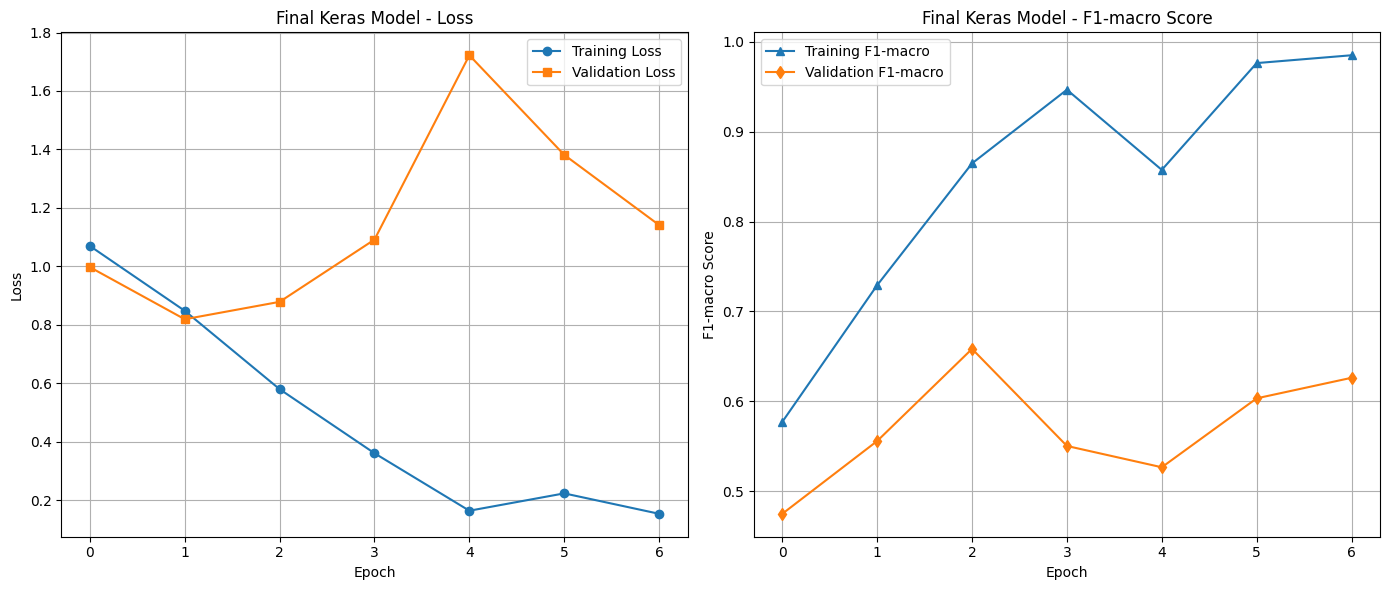

In [95]:
print("\nPlotting Final Keras Model History...")
plot_history(final_history, "Final Keras Model", final_f1_callback)


Plotting Final Scratch Model History...


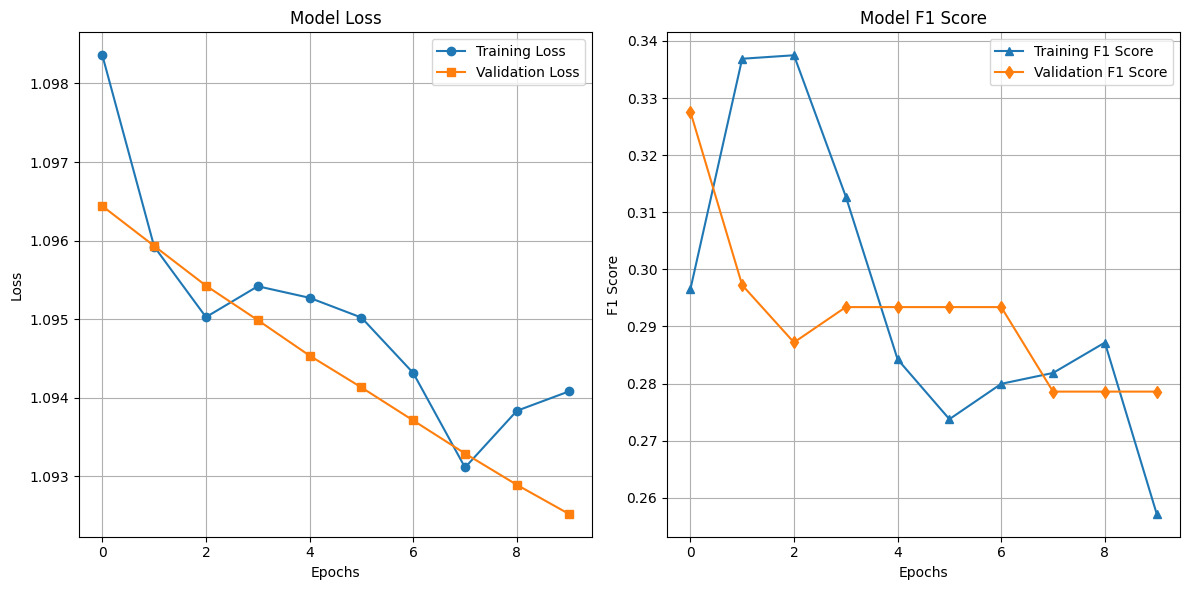

In [96]:
print("\nPlotting Final Scratch Model History...")
lstm_final_scratch.plot_history(final_scratch_history)

In [97]:
print("\n=== DETAILED CLASSIFICATION REPORTS ===")
print("Getting final predictions for classification reports...")

# Get Keras model predictions (use the predictions from comparison section)
if 'keras_pred_full' not in locals():
    keras_pred_full = np.argmax(loaded_keras_model.predict(X_test_vec, verbose=0), axis=1)

# Get from-scratch model predictions (from the comparison model)
if 'scratch_pred_full' not in locals():
    scratch_pred_full = np.argmax(lstm_scratch.predict(X_test_vec, batch_size=32), axis=1)

print("\nKeras Model Classification Report:")
try:
    print(classification_report(y_test_np, keras_pred_full, 
                              target_names=['Negative', 'Neutral', 'Positive']))
except Exception as e:
    print(f"Error generating Keras classification report: {e}")
    print("Using final model predictions...")
    keras_pred_final = np.argmax(final_model.predict(X_test_vec, verbose=0), axis=1)
    print(classification_report(y_test_np, keras_pred_final, 
                              target_names=['Negative', 'Neutral', 'Positive']))

print("\nFrom-scratch Model Classification Report:")
try:
    print(classification_report(y_test_np, scratch_pred_full, 
                              target_names=['Negative', 'Neutral', 'Positive']))
except Exception as e:
    print(f"Error generating from-scratch classification report: {e}")
    print("Using trained scratch model predictions...")
    print(classification_report(y_test_np, scratch_preds_argmax, 
                              target_names=['Negative', 'Neutral', 'Positive']))


=== DETAILED CLASSIFICATION REPORTS ===
Getting final predictions for classification reports...

Keras Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.45      0.53       153
     Neutral       0.50      0.56      0.53        96
    Positive       0.75      0.91      0.82       151

    accuracy                           0.65       400
   macro avg       0.63      0.64      0.63       400
weighted avg       0.65      0.65      0.64       400


From-scratch Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.45      0.53       153
     Neutral       0.50      0.56      0.53        96
    Positive       0.75      0.91      0.82       151

    accuracy                           0.65       400
   macro avg       0.63      0.64      0.63       400
weighted avg       0.65      0.65      0.64       400



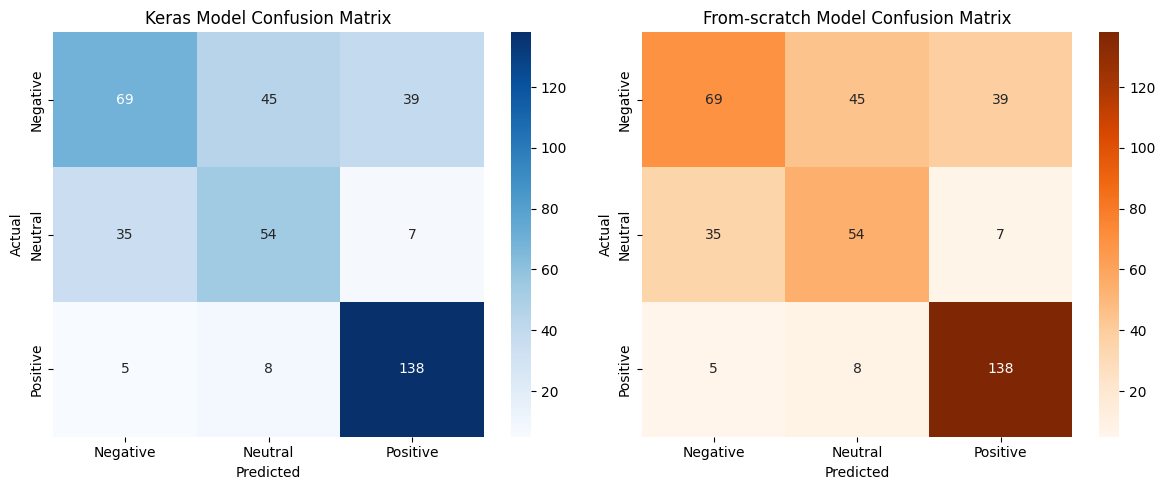

In [98]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

try:
    # Keras confusion matrix
    cm_keras = confusion_matrix(y_test_np, keras_pred_full)
    sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues', ax=axes[0],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[0].set_title('Keras Model Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
except Exception as e:
    print(f"Error creating Keras confusion matrix: {e}")
    keras_pred_fallback = np.argmax(final_model.predict(X_test_vec, verbose=0), axis=1)
    cm_keras = confusion_matrix(y_test_np, keras_pred_fallback)
    sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues', ax=axes[0],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[0].set_title('Keras Model Confusion Matrix (Final)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

try:
    # From-scratch confusion matrix
    cm_scratch = confusion_matrix(y_test_np, scratch_pred_full)
    sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[1].set_title('From-scratch Model Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
except Exception as e:
    print(f"Error creating from-scratch confusion matrix: {e}")
    cm_scratch = confusion_matrix(y_test_np, scratch_preds_argmax)
    sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[1].set_title('From-scratch Model Confusion Matrix (Trained)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('lstm_confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Batch Inference Testing (Bonus Feature)

In [99]:
print("\n=== TESTING BATCH INFERENCE (BONUS) ===")

# Test different batch sizes
batch_sizes = [1, 8, 16, 32, 64]
test_sample = X_test_vec[:100] 

print("Testing batch inference dengan berbagai ukuran batch:")
print(f"{'Batch Size':<12} {'Predictions Shape':<20} {'Time (s)':<10}")
print("-" * 50)

import time

# Test with the loaded scratch model
test_model = lstm_scratch if 'lstm_scratch' in locals() else lstm_final_scratch

for batch_size in batch_sizes:
    start_time = time.time()
    
    try:
        # Test batch prediction
        predictions = test_model.predict(test_sample, batch_size=batch_size)
        end_time = time.time()
        inference_time = end_time - start_time
        
        print(f"{batch_size:<12} {str(predictions.shape):<20} {inference_time:<10.4f}")
    except Exception as e:
        print(f"{batch_size:<12} {'Error':<20} {str(e)[:20]}")

print("\n✓ Batch inference testing completed!")

# Additional batch inference demonstration
print("\n=== BATCH INFERENCE DEMONSTRATION ===")
print("Demonstrating different batch sizes with timing...")

demo_samples = [10, 50, 100, 200]
for n_samples in demo_samples:
    if n_samples <= len(X_test_vec):
        sample_data = X_test_vec[:n_samples]
        
        start_time = time.time()
        predictions = test_model.predict(sample_data, batch_size=32)
        end_time = time.time()
        
        print(f"Samples: {n_samples:>3}, Time: {end_time-start_time:.4f}s, "
              f"Output shape: {predictions.shape}")


=== TESTING BATCH INFERENCE (BONUS) ===
Testing batch inference dengan berbagai ukuran batch:
Batch Size   Predictions Shape    Time (s)  
--------------------------------------------------
1            (100, 3)             4.3007    
8            (100, 3)             0.9999    
16           (100, 3)             1.5996    
32           (100, 3)             1.1679    
64           (100, 3)             0.9026    

✓ Batch inference testing completed!

=== BATCH INFERENCE DEMONSTRATION ===
Demonstrating different batch sizes with timing...
Samples:  10, Time: 0.1626s, Output shape: (10, 3)
Samples:  50, Time: 0.5175s, Output shape: (50, 3)
Samples: 100, Time: 0.9199s, Output shape: (100, 3)
Samples: 200, Time: 1.6230s, Output shape: (200, 3)
